In [1]:
# Common imports
import numpy as np
import tensorflow.keras as tf
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Conv2D
from keras.layers import Dense
import pandas as pd
from pathlib import Path
import datetime, time
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = np.load('/content/drive/MyDrive/Ferguson_fire_train/Ferguson_fire_train.npy')
test = np.load('/content/drive/MyDrive/Ferguson_fire_test/Ferguson_fire_test.npy')
print(f"Before reshaping: {np.shape(train)}")
print(f"Before reshaping: {np.shape(test)}")

Before reshaping: (12500, 256, 256)
Before reshaping: (5000, 256, 256)


In [5]:
rows,cols=np.shape(train)[1],np.shape(train)[2]
# Add a channel dimension
x_train = train[..., np.newaxis]
print(x_train.shape)  # Adding an extra dimension for channels
#x_train = x_train.reshape((x_train.shape[0], 1, rows, cols, 1))
y_train = train.reshape((train.shape[0], rows, cols, 1))
x_test = test[..., np.newaxis]  # Adding an extra dimension for channels
#x_test = x_test.reshape((x_test.shape[0], 1, rows, cols, 1))
y_test = test.reshape((test.shape[0], rows, cols, 1))

print("Shape of x_train: ", x_train.shape) 
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", x_test.shape) 
print("Shape of y_test: ", y_test.shape)

(12500, 256, 256, 1)
Shape of x_train:  (12500, 256, 256, 1)
Shape of y_train:  (12500, 256, 256, 1)
Shape of x_test:  (5000, 256, 256, 1)
Shape of y_test:  (5000, 256, 256, 1)


In [6]:
def divide_dataset(data, num_splits):
    datasets = np.array_split(data, num_splits)
    return datasets

In [7]:
x_train_datasets = divide_dataset(x_train,125)
y_train_datasets = divide_dataset(y_train,125)

In [8]:
x_train_fnl = []
for i in x_train_datasets:
  new_data = []
  for j in range(np.shape(i)[0]-20):
    new_data.append([i[j],i[j+10]])
  new_data = np.array(new_data)
  x_train_fnl.append(new_data)
y_train_fnl = []
for i in y_train_datasets:
  new_data =[]
  for j in range(np.shape(i)[0]-20):
    new_data.append(i[j+20])
  new_data = np.array(new_data)
  y_train_fnl.append(new_data)
print('Shape of x_train_fnl:',np.shape(x_train_fnl))
print('Shape of y_train_fnl:',np.shape(y_train_fnl))

Shape of x_train_fnl: (125, 80, 2, 256, 256, 1)
Shape of y_train_fnl: (125, 80, 256, 256, 1)


In [13]:
# Define the model
model = Sequential()

model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                     input_shape=(2, rows, cols, 1),  # None allows for variable length sequences
                     padding='same', return_sequences=False))  # False because we're predicting the next step only
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
for i in range(125):
    x_train = x_train_fnl[i]  
    y_train = y_train_fnl[i]  
    history = model.fit(x_train, y_train, batch_size=20, epochs=10)

Epoch 1/10
4/4 [==============================] - 6s 100ms/step - loss: 0.6868 - accuracy: 0.9997
Epoch 2/10
4/4 [==============================] - 0s 97ms/step - loss: 0.6702 - accuracy: 0.9996
Epoch 3/10
4/4 [==============================] - 0s 97ms/step - loss: 0.6533 - accuracy: 0.9996
Epoch 4/10
4/4 [==============================] - 0s 98ms/step - loss: 0.6361 - accuracy: 0.9996
Epoch 5/10
4/4 [==============================] - 0s 98ms/step - loss: 0.6185 - accuracy: 0.9996
Epoch 6/10
4/4 [==============================] - 0s 98ms/step - loss: 0.6006 - accuracy: 0.9997
Epoch 7/10
4/4 [==============================] - 0s 98ms/step - loss: 0.5823 - accuracy: 0.9997
Epoch 8/10
4/4 [==============================] - 0s 98ms/step - loss: 0.5636 - accuracy: 0.9997
Epoch 9/10
4/4 [==============================] - 0s 98ms/step - loss: 0.5446 - accuracy: 0.9997
Epoch 10/10
4/4 [==============================] - 0s 98ms/step - loss: 0.5253 - accuracy: 0.9998
Epoch 1/10
4/4 [============

In [15]:
x_test.shape

(5000, 256, 256, 1)

In [20]:


x_test_fnl = []
for i in range(len(x_test)-20): 
    x_test_fnl.append([x_test[i], x_test[i+10]])  # Create pairs of (t=n, t=n+10)

x_test_fnl = np.array(x_test_fnl)  

y_test_fnl = []
for i in range(len(y_test)-20):
  y_test_fnl.append(y_test[i+20])

y_test_fnl = np.array(y_test_fnl)

print(x_test_fnl.shape)
print(y_test_fnl.shape)

(4980, 2, 256, 256, 1)
(4980, 256, 256, 1)


In [21]:
y_pred = model.predict(x_test_fnl)

156/156 [==============================] - 10s 59ms/step


In [22]:
mse_test = mean_squared_error(y_pred.reshape(np.shape(y_pred)[0],-1),y_test_fnl.reshape(np.shape(y_test_fnl)[0],-1))

In [23]:
print(mse_test)

0.019601276


In [1]:
def plot_img(data,ts):
  fig,axes = plt.subplots(1,len(ts),figsize=[20,8])
  for i, ax in enumerate(axes.ravel()):
    im = ax.imshow(data[ts[i]])
    ax.set_title(str(ts[i]))
    fig.colorbar(im,ax)

In [25]:
background = np.load('/content/drive/MyDrive/Ferguson_fire_background/Ferguson_fire_background.npy')
print(f"Shape of background: {np.shape(background)}")
obs = np.load('/content/drive/MyDrive/Ferguson_fire_background/Ferguson_fire_obs.npy')
print(f"Shape of obs: {np.shape(obs)}")

Shape of background: (5, 256, 256)
Shape of obs: (5, 256, 256)


In [26]:
background = background[..., np.newaxis]  # Adding an extra dimension for channels
print(background.shape)

(5, 256, 256, 1)


In [27]:
back_fnl = []
for i in range(len(background)-2):
  back_fnl.append([background[i],background[i+1]])
back_fnl = np.array(back_fnl)
print(back_fnl.shape)

(3, 2, 256, 256, 1)


In [28]:
pred = model.predict(back_fnl)

1/1 [==============================] - 0s 101ms/step


In [37]:
mse_obs = mean_squared_error(pred.reshape(3,-1),obs[2:].reshape(3,-1))

In [38]:
print(mse_obs)

0.08026495562944305


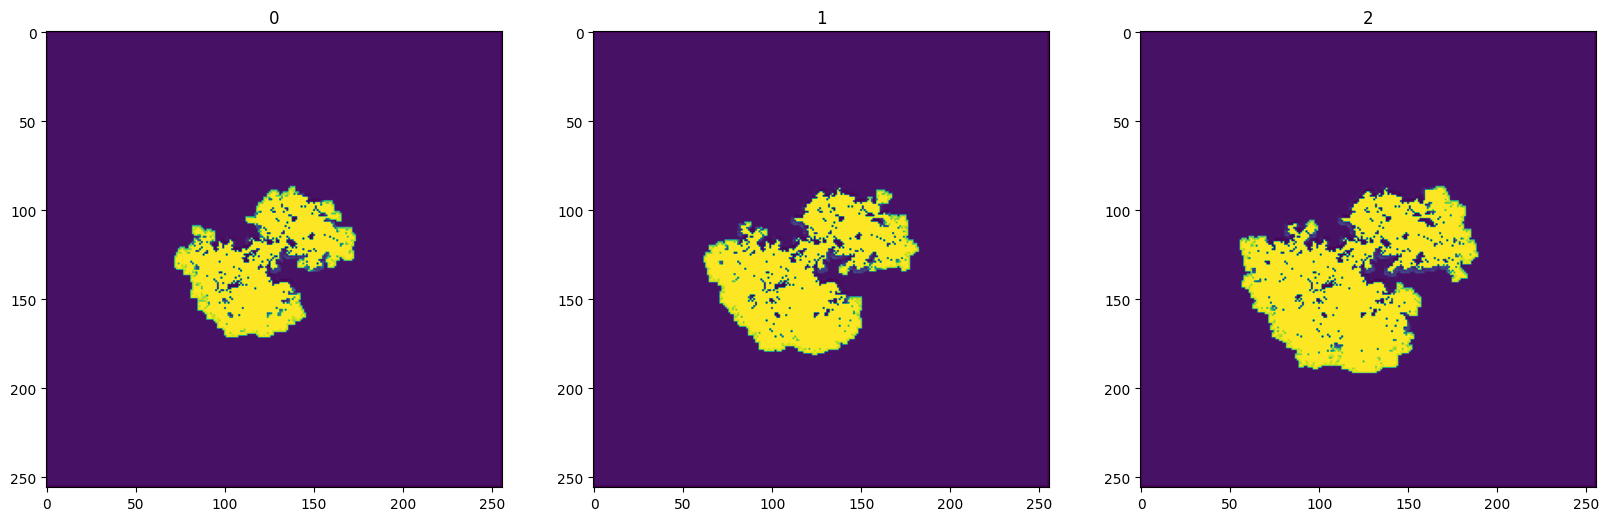

In [ ]:
plot_img(pred,[0,1,2,3])

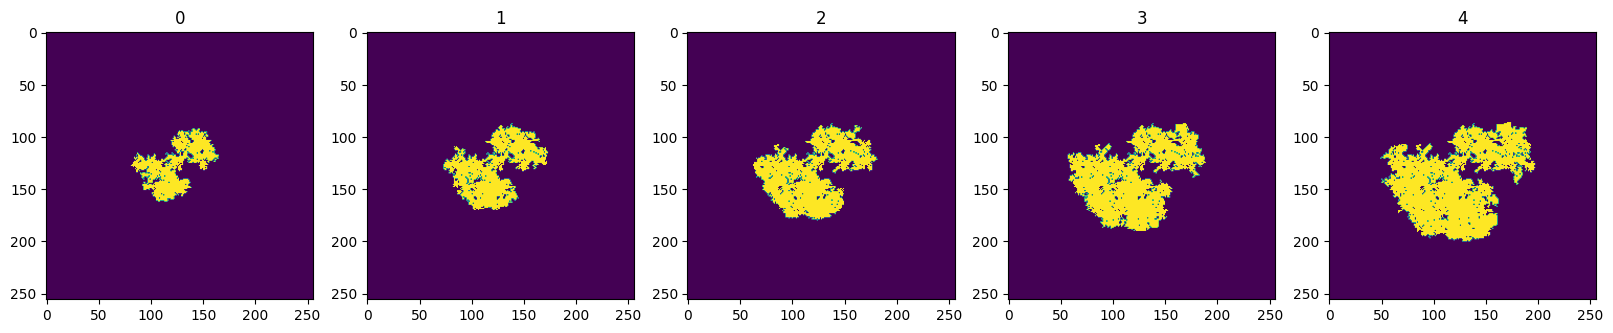

In [41]:
plot_img(background,[0,1,2,3,4])

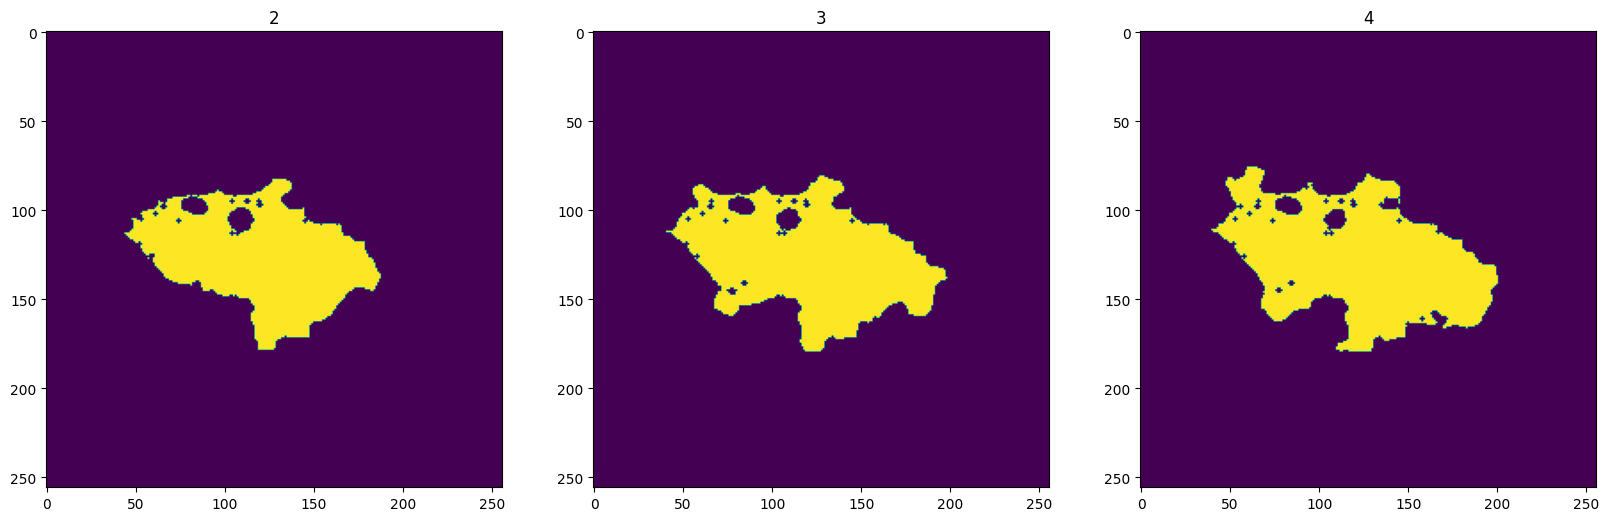

In [36]:
plot_img(obs,[2,3,4])